In [1]:
########################################################################
#    July 03, 2019                                                     #
#    11:45                                                             #
#    Created by: Ankit Chillar, Kunal Gehlot                           #
#    Company: Panda Projects                                           #
########################################################################

In [2]:
SAMPLE_PATH = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/sample images/*.dcm'
DATASET_PATH = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/dicom-images-train/*/*/*.dcm'
TEST_PATH = 'D:\OneDrive\Desktop\siim-acr-pneumothorax-segmentation\dicom-images-test\*\*.dcm'
RLE_SAMPLE = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv'
RLE_PATH = 'D:/OneDrive/Desktop/siim-acr-pneumothorax-segmentation/train-rle.csv'

In [3]:
import os
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import cv2
import sys
import keras.layers as kl
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from collections import defaultdict
from pydicom.data import get_testdata_files
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, Conv2DTranspose, Activation
from collections import defaultdict
from pydicom.data import get_testdata_files
from keras.models import Sequential

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.Session()
tf.device('/gpu:0')


def allDone():
  display(Audio(url='Siren.wav', autoplay=True))


Using TensorFlow backend.


In [4]:
def PixelArray(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    print(dataset.pixel_array)
    print(plt.cm.bone)
    plt.show()

In [5]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [6]:
# filename = get_testdata_files('rtplan.dcm')[0]
files = sorted(glob(DATASET_PATH))

In [7]:
len(files)

10712

In [8]:
RLEs = pd.read_csv(RLE_PATH)

In [9]:
len(RLEs)

11582

In [10]:
RLEsL = defaultdict(list)

In [11]:
for image_id, rle in zip(RLEs['ImageId'], RLEs[' EncodedPixels']):
    RLEsL[image_id].append(rle)
annotated = {k: v for k, v in RLEsL.items() if v[0] != ' -1'}
print("%d of %d images are annotated (Positive) " % (len(annotated), len(RLEsL)))

2379 of 10675 images are annotated (Positive) 


In [12]:
print('Missing values are: (DROP THESE)', len(files) - len(RLEsL))

Missing values are: (DROP THESE) 37


In [13]:
count = 0
for i in files:
    
#     print(RLEs.ImageId.str.contains(i.split('\\')[-1][:-4]))
    if RLEs.ImageId.str.contains(i.split('\\')[-1][:-4]).any():
        count = count
    else:
        files.remove(i)
        print("False")
        count += 1
        

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [14]:
indices = RLEs[RLEs.duplicated(subset='ImageId', keep='first')]

In [15]:
ds1 = set([tuple(line) for line in RLEs.values])
ds2 = set([tuple(line) for line in indices.values])

In [16]:
len(ds1.difference(ds2))

10675

In [17]:
RLEs = pd.DataFrame(list(ds1.difference(ds2)), columns = ['ImageId', ' EncodedPixels'])

In [18]:
RLEs = RLEs.set_index('ImageId')

Visualizing the part of the full dataset .........
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
True
True
False
True
False
False
True
False
False
False
False
True
False
False
False
True
True
False
False
True
False
False
False
False
False
False
True
False
False
False
True
False
False
False
True


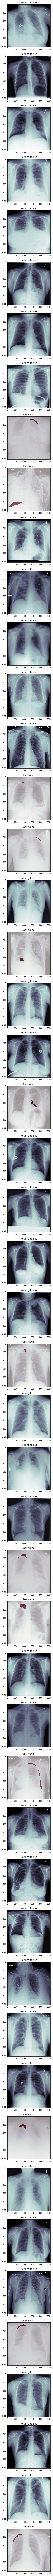

In [19]:
print("Visualizing the part of the full dataset .........")

start = 20
numberOfImages = 50

fig, ax = plt.subplots(nrows = numberOfImages, ncols = 1, sharey=True, figsize=(250, 250))
for q, path in enumerate(glob(DATASET_PATH)[start:start+numberOfImages]):
    dataset = pydicom.dcmread(path)
    ax[q].imshow(dataset.pixel_array, cmap = plt.cm.bone)
    compare = RLEs[' EncodedPixels'].loc[path.split('\\')[-1][:-4]]
    print(compare != ' -1')
    if compare != ' -1':
        mask = rle2mask(RLEs[' EncodedPixels'].loc[path.split('\\')[-1][:-4]], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.6, cmap='Reds')
    else:
        ax[q].set_title('Nothing to see')

In [31]:
files = files[:500]

In [32]:
len(files)

500

In [33]:
height = 1024
width = 1024
binSeg = 1

X_train = np.zeros((len(files), height, width, binSeg), dtype=np.uint8)
Y_train = np.zeros((len(files), height, width, 1), dtype=np.bool)

print('Getting train images and masks ... ')
sys.stdout.flush()

for n, _id in tqdm_notebook(enumerate(files), total=len(files)):
    dataset = pydicom.read_file(_id)
    
    X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
    if '-1' in RLEs.loc[_id.split('\\')[-1][:-4],' EncodedPixels']:
        Y_train[n] = np.zeros((1024, 1024, 1))
    else:
        Y_train[n] = np.expand_dims(rle2mask(RLEs.loc[_id.split('\\')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
print("Got'em")

Getting train images and masks ... 



Got'em


In [34]:
height = 128
width = 128
X_train = X_train.reshape((-1, height, width, 1))
Y_train = Y_train.reshape((-1, height, width, 1))

In [35]:
def dice_coef(y_true, y_pred, smooth=0.5):
    print(binSeg, 'in dice')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [25]:
#allDone()

In [36]:
inputs = Input((height, width, binSeg))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

1 in dice
1 in dice
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 128, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 128, 128, 8)  584         conv2d_34[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_35[0][0]                  
_________________________________________________________________________________________

In [38]:
model.fit(X_train, Y_train, validation_split=.2, batch_size=50, epochs=50)

Train on 25600 samples, validate on 6400 samples
Epoch 1/50


InternalError: CUB reduce errorinvalid configuration argument
	 [[{{node metrics_2/dice_coef/Sum_1}}]]
	 [[{{node metrics_2/dice_coef/div_no_nan}}]]

In [ ]:
allDone()